In [180]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from os.path import isfile, isdir
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
% matplotlib inline

In [169]:
# load in train & test csv
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [114]:
print('Number of Samples in train data:',train.shape[0])
print()
print('Number of Samples in test data:', test.shape[0])

Number of Samples in train data: 42000

Number of Samples in test data: 8400


In [120]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


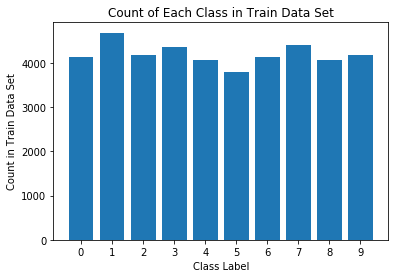

In [144]:
df = pd.DataFrame(train[['pixel0','label']].groupby('label').count())
import matplotlib.pyplot as plt
y_pos = np.arange(10)
objects  = range(0,10)
plt.bar(y_pos,df.pixel0.values)
plt.xticks(y_pos, objects)
plt.ylabel("Count in Train Data Set")
plt.xlabel("Class Label")
plt.title("Count of Each Class in Train Data Set")
plt.show()

It can be seen from the above chart that the there is  uniform distribution in the train data set.

In [164]:
rng = np.random.RandomState()
def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, 784)
    
    batch_y = eval(dataset_name + '_y')[[batch_mask]].reshape(-1, 10)
    return(batch_x,batch_y)

def imageMatrix(df, n):
    img = df.iloc[n,:].values.reshape(-1,28,28)
    return(img[0])

In [166]:
testdata_x = test.iloc[:,range(0,784)].values/255

I am running a multi layer perceptron with one hidden layer having 500 hidden units. I am using relu activation function and adam optimizer. I am using stratified 5-fold cross validation to repeat the experiment. I am also using a convolution neural network to compare the results with vanilla neural networks.

In [183]:
count = 1
accuracy_NN = []
kf = StratifiedKFold(n_splits = 5, shuffle=True)
kf.get_n_splits(train)
for train_index, val_index in kf.split(train, train.label):
    #Train Data
    traindata_x = train.iloc[train_index,range(1,785)].values/255
    enc = OneHotEncoder(sparse = False)
    traindata_y = enc.fit_transform(train.iloc[train_index,0].values.reshape(len(train_index), 1))
    #Validation Data
    #validation Data
    valdata_x = train.iloc[val_index,range(1,785)].values/255
    valdata_y = enc.fit_transform(train.iloc[val_index,0].values.reshape(len(val_index), 1))
    #Declaring the neural network parameters
    learning_rate = 0.01
    epochs = 10
    batch_size = 128
    #Declaring the input and output placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])
    # now declare the weights connecting the input to the hidden layer
    W1 = tf.Variable(tf.random_normal([784, 500], stddev=0.03), name='W1')
    b1 = tf.Variable(tf.random_normal([500]), name='b1')
    # and the weights connecting the hidden layer to the output layer
    W2 = tf.Variable(tf.random_normal([500, 10], stddev=0.03), name='W2')
    b2 = tf.Variable(tf.random_normal([10]), name='b2')
    # calculate the output of the hidden layer
    hidden_out = tf.add(tf.matmul(x, W1), b1)
    hidden_out = tf.nn.relu(hidden_out)
    # now calculate the hidden layer output - in this case, let's use a softmax activated
    # output layer
    output_layer = tf.matmul(hidden_out, W2) + b2
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output_layer,labels=  y))
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # finally setup the initialisation operator
    init_op = tf.global_variables_initializer()

    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(output_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    print("Results For Repetiton:", count)
    # start the session
    with tf.Session() as sess:
        # initialise the variables
        sess.run(init_op)
        total_batch = int(len(traindata_x) / batch_size)
        for epoch in range(epochs):
            avg_cost = 0
            for i in range(total_batch):
                batch_x, batch_y = batch_creator(128, len(traindata_x), 'traindata')
                _, c= sess.run([optimiser, cost], feed_dict={x: batch_x, y: batch_y})

                avg_cost += c / total_batch
            print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost),
                  "Accuracy:", sess.run(accuracy, feed_dict={x: valdata_x, y: valdata_y}))
        print("Final Accuracy For Repetition ", count,":", sess.run(accuracy, feed_dict={x: valdata_x, y: valdata_y}))
        accuracy_NN.extend([sess.run(accuracy, feed_dict={x: valdata_x, y: valdata_y})])
        count = count+1
        predict = tf.argmax(output_layer, 1)
        pred_NN = predict.eval({x: testdata_x.reshape(-1, 784)})    

Results For Repetiton: 1
Epoch: 1 cost = 0.288 Accuracy: 0.955741
Epoch: 2 cost = 0.101 Accuracy: 0.961452
Epoch: 3 cost = 0.083 Accuracy: 0.95931
Epoch: 4 cost = 0.064 Accuracy: 0.961689
Epoch: 5 cost = 0.061 Accuracy: 0.965497
Epoch: 6 cost = 0.053 Accuracy: 0.965378
Epoch: 7 cost = 0.051 Accuracy: 0.960143
Epoch: 8 cost = 0.049 Accuracy: 0.966805
Epoch: 9 cost = 0.057 Accuracy: 0.965616
Epoch: 10 cost = 0.039 Accuracy: 0.967757
Final Accuracy For Repetition  1 : 0.967757
Results For Repetiton: 2
Epoch: 1 cost = 0.268 Accuracy: 0.952279
Epoch: 2 cost = 0.107 Accuracy: 0.963227
Epoch: 3 cost = 0.084 Accuracy: 0.956682
Epoch: 4 cost = 0.065 Accuracy: 0.960966
Epoch: 5 cost = 0.061 Accuracy: 0.957753
Epoch: 6 cost = 0.058 Accuracy: 0.962751
Epoch: 7 cost = 0.049 Accuracy: 0.962275
Epoch: 8 cost = 0.047 Accuracy: 0.968583
Epoch: 9 cost = 0.047 Accuracy: 0.96775
Epoch: 10 cost = 0.045 Accuracy: 0.967869
Final Accuracy For Repetition  2 : 0.967869
Results For Repetiton: 3
Epoch: 1 cost = 0

Predicted Number:  2

The actual image is shown below:


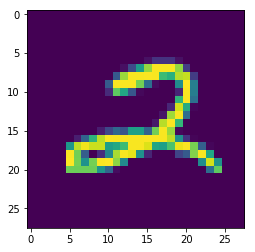

In [170]:
which = 3898
print("Predicted Number: ",pred[which])
print()
print("The actual image is shown below:")
from matplotlib import pyplot as plt
plt.imshow(imageMatrix(test, which), interpolation='nearest')
plt.show()

I am using convolution neural network with two convolution layer with 6 and 16 filters. I am also using a fully dense layer with 128 perceptrons and an output layer with 10 perceptrons. I am using pooling and relu layers in between as well. I am using the same stratified 5 fold cross validation for repetitions.

## Implementing Convolution Neural Network

In [184]:
from sklearn.model_selection import KFold
count = 1
accuracy_CNN = []
kf = StratifiedKFold(n_splits = 5, shuffle=True)
kf.get_n_splits(train)
for train_index, val_index in kf.split(train,train.label):
    #Train Data
    traindata_x = train.iloc[train_index,range(1,785)].values/255
    enc = OneHotEncoder(sparse = False)
    traindata_y = enc.fit_transform(train.iloc[train_index,0].values.reshape(len(train_index), 1))
    #Validation Data
    #validation Data
    valdata_x = train.iloc[val_index,range(1,785)].values/255
    valdata_y = enc.fit_transform(train.iloc[val_index,0].values.reshape(len(val_index), 1))
    #Declaring the neural network parameters
    learning_rate = 0.01
    epochs = 10
    batch_size = 128
    #Defining the placeholders
    #Placeholder variable for the input images
    x = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
    # Reshape it into [num_images, img_height, img_width, num_channels]
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    y = tf.placeholder(tf.float32, [None, 10])
    
    
    #weights and biases for first convolution layer
    W1 = tf.Variable(tf.truncated_normal([5,5,1,6], stddev=0.03))
    b1 = tf.Variable(tf.constant(0.03, shape=[6]))

    #First Convlution Layer
    conv1 = tf.add(tf.nn.conv2d(input=x_image, filter=W1, strides=[1, 1, 1, 1], padding='SAME'),b1)
    #First Pooling Layer
    pool1 = tf.nn.max_pool(value=conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #First Relu Layer
    relu1 = tf.nn.relu(pool1)

    #Weights and biases for second convolution layer
    W2 = tf.Variable(tf.truncated_normal([5,5,6,16], stddev=0.03))
    b2 = tf.Variable(tf.constant(0.03, shape=[16]))

    #Second convolution layer
    conv2 = tf.add(tf.nn.conv2d(input=relu1, filter=W2, strides=[1, 1, 1, 1], padding='SAME'),b2)
    pool2 = tf.nn.max_pool(value=conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    relu2 = tf.nn.relu(pool2)
    num_features = relu2.get_shape()[1:4].num_elements()
    layer_flat = tf.reshape(relu2, [-1, num_features])

    #Weights and biases for first fully connected layer
    W3 = tf.Variable(tf.truncated_normal([num_features, 128], stddev=0.03))
    b3 = tf.Variable(tf.constant(0.03, shape=[128]))

    fc1 = tf.matmul(layer_flat, W3) + b3
    relu3 = tf.nn.relu(fc1)

    W4 = tf.Variable(tf.truncated_normal([128, 10], stddev=0.03))
    b4 = tf.Variable(tf.constant(0.03, shape=[10]))

    fc2 = tf.matmul(relu3, W4) + b4
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = fc2,labels=  y))
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # finally setup the initialisation operator
    init_op = tf.global_variables_initializer()

    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(fc2, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # start the session
    print("Results For Repetiton:", count)
    with tf.Session() as sess:
        # initialise the variables
        sess.run(init_op)
        total_batch = int(len(traindata_x) / batch_size)
        for epoch in range(epochs):
            avg_cost = 0
            for i in range(total_batch):
                batch_x, batch_y = batch_creator(128, len(traindata_x), 'traindata')
                _, c= sess.run([optimiser, cost], feed_dict={x: batch_x, y: batch_y})

                avg_cost += c / total_batch
            print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost),
                  "Accuracy:", sess.run(accuracy, feed_dict={x: valdata_x, y: valdata_y}))
        print("Final Accuracy for repetition", count,":", sess.run(accuracy, feed_dict={x: valdata_x, y: valdata_y}))
        
        accuracy_CNN.extend([sess.run(accuracy, feed_dict={x: valdata_x, y: valdata_y})])
        count = count + 1
        predict = tf.argmax(fc2, 1)
        pred = predict.eval({x: testdata_x.reshape(-1, 784)})   

Results For Repetiton: 1
Epoch: 1 cost = 0.290 Accuracy: 0.974539
Epoch: 2 cost = 0.078 Accuracy: 0.981321
Epoch: 3 cost = 0.056 Accuracy: 0.978108
Epoch: 4 cost = 0.052 Accuracy: 0.97906
Epoch: 5 cost = 0.044 Accuracy: 0.982153
Epoch: 6 cost = 0.042 Accuracy: 0.979893
Epoch: 7 cost = 0.038 Accuracy: 0.97906
Epoch: 8 cost = 0.038 Accuracy: 0.98251
Epoch: 9 cost = 0.036 Accuracy: 0.978346
Epoch: 10 cost = 0.034 Accuracy: 0.979417
Final Accuracy for repetition 1 : 0.979417
Results For Repetiton: 2
Epoch: 1 cost = 0.282 Accuracy: 0.97013
Epoch: 2 cost = 0.071 Accuracy: 0.979531
Epoch: 3 cost = 0.053 Accuracy: 0.983339
Epoch: 4 cost = 0.044 Accuracy: 0.981078
Epoch: 5 cost = 0.040 Accuracy: 0.982268
Epoch: 6 cost = 0.039 Accuracy: 0.986076
Epoch: 7 cost = 0.034 Accuracy: 0.981673
Epoch: 8 cost = 0.031 Accuracy: 0.981554
Epoch: 9 cost = 0.035 Accuracy: 0.981078
Epoch: 10 cost = 0.040 Accuracy: 0.978817
Final Accuracy for repetition 2 : 0.978817
Results For Repetiton: 3
Epoch: 1 cost = 0.310

In [189]:
print("Mean accuracy with neural networks:", np.mean(accuracy_NN))
print()
print("Meanaccuracy with convolution neural networks:",np.mean(accuracy_CNN))

Mean accuracy with neural networks: 0.9675

Meanaccuracy with convolution neural networks: 0.979095


The result show that CNN perform slightly better than the multi layer perceptrons. The CNN while on the other hald due to its complex design takes very long train and has a high number of parameters.